# Classification Analysis
This notebook will contain classification analysis for both the sensed and pipelined algorithms. Analysis will be preformed in regards for the sensed and pipelined algorthms themselves, as well as the ensemble algorithms. The analysis for the ensemble algorithm will focus on the HAMF android phones and the HAHF iOS phones.

## Dependencies

In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv

In [2]:
# for analysized view
import emeval.analysed.phone_view as eapv
import emeval.analysed.location_smoothing as location_smoothing

In [3]:
import emeval.metrics.segmentation as ems

In [4]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format

In [5]:
import numpy as np
import pathlib

In [6]:
# For plots
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# For maps
import geopandas as gpd

In [8]:
output_dir = pathlib.Path("./images")
if not output_dir.exists():
    output_dir.mkdir()

## Load in Phone Views from the file spec

In [9]:
## Retrieve the specs for the given experiment.

DATASTORE_LOC = "bin/data"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd_la = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")
sd_sj = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "car_scooter_brex_san_jose")
sd_ucb = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

After iterating over 1 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00


In [10]:
%%capture
pv_la = eipv.PhoneView(sd_la)
pv_sj = eipv.PhoneView(sd_sj)
pv_ucb = eipv.PhoneView(sd_ucb)

## %%capture is a cell-level Jupyter magic function that redirects the stdout to null. 

### Get sensed data for each trip

In [11]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
ems.fill_sensed_section_ranges(pv_sj)
ems.fill_sensed_section_ranges(pv_ucb)

## Fill in the sensed sections.

## Get sensed and ground truth temporal histories (timelines)

In [12]:
def fetch_trajectories(spec_id: str, run_ix: int, with_ends: bool = False) -> pd.DataFrame:

    '''
    Return a reference trajectory datafrane given a spec ID and a trip ID.
    e.g.: for spec_id=car_scooter_brex_san_jose, run_ix=0, and with_ends=True,
    the function fetches the following files and concatenates them in a dataframe along axis=0:

    car_scooter_brex_san_jose
        | - no_ends
        | - with_ends
            | - bus trip with e-scooter access
                | - city_bus_rapid_transit_0
                | - city_escooter_0
                | - walk_back_from_bus_0
            | - freeway_driving_weekday
                | - freeway_driving_weekday_0
    '''

    root = pathlib.Path("./bin/data")
    return_file = pd.DataFrame()

    workdir = root
    assert (workdir / spec_id).exists(), f"{spec_id} not found."

    workdir = workdir / spec_id
    assert workdir.is_dir(), f"{spec_id} found, but is not a directory."

    if with_ends:
        found_glob = list(workdir.glob(f'./with_ends/*/*_{run_ix}'))
    else:
        found_glob = list(workdir.glob(f'./no_ends/*/*_{run_ix}'))

    assert len(found_glob) > 0, f"No files found for {spec_id=}, {run_ix=}"

    df = pd.DataFrame()

    for file in found_glob:
        tdf = pd.read_csv(file)
        # Ignore the first (Unnamed: 0) column.
        tdf = tdf.iloc[:, 1:]
        df = pd.concat([df, tdf], axis=0)
    
    return df.reset_index(drop=True, inplace=False)

In [13]:
def get_reference_trajectory(pv, os, role, with_ends=False):

    '''
    Return a list of dataframes for every run in a given `PhoneView`. Filters by `os` and `role`.
    '''

    dfs = []

    for phone_os, phone_map in pv.map().items():
        if os != phone_os:
            continue
        for phone_label, phone_detail_map in phone_map.items():
            if "control" in phone_detail_map["role"]:
                continue
            for run_ix, run in enumerate(phone_detail_map["evaluation_ranges"]):
                if run['eval_role_base'] != role:
                    continue
                
                df = fetch_trajectories(pv.spec_details.CURR_SPEC_ID, run_ix, with_ends=with_ends)
                df['run_ix'] = run_ix

                dfs.append(df.copy())
    
    return dfs

In [14]:
def get_trip_ss_and_gts_timeline(pv, os, role):
    assert os in ['android', 'ios'], 'UNKNOWN OS'
    assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
    trips = []
    for phone_os, phone_map in pv.map().items():
        if os != phone_os:
            continue
        for phone_label, phone_detail_map in phone_map.items():
            if "control" in phone_detail_map["role"]:
                continue
            for run_ix, run in enumerate(phone_detail_map["evaluation_ranges"]):
                if run['eval_role_base'] != role:
                    continue

                tr_ss  = []
                tr_gts = []
                ref_trajectories = []
                ss_location = []
                
                # Start iterating over trips.
                for i, trip in enumerate(run["evaluation_trip_ranges"]):

                    # We also need the sensed trip location for computing the support.
                    ss_location.append(trip['location_df'])

                    # Start iterating over every sensed section of the trip.
                    for ss in trip["sensed_section_ranges"]:

                        tr_ss.append(ss)

                    # Start iterating over every evaluation section of the trip.
                    for section in trip["evaluation_section_ranges"]:

                        ## get the ground truth section data
                        section_gt_leg = pv.spec_details.get_ground_truth_for_leg(trip['trip_id_base'],
                                                                                  section['trip_id_base'],
                                                                                  trip['start_ts'],
                                                                                  trip['end_ts'])
                        
                        if section_gt_leg["type"] == "WAITING":
                            continue

                        gts = {'start_ts': section['start_ts'], 
                               'end_ts': section['end_ts'], 
                               'mode': section_gt_leg['mode']
                               }

                        tr_gts.append(gts)

                # now, we build a timeline for each trip
                trip = trip.copy()
                trip['ss_timeline']  = tr_ss
                trip['gts_timeline'] = tr_gts
                trip['location_data'] = ss_location
                
                trips.append(trip)
    
    return trips

## Define the Base Mode Maps

#### raw base mode map

In [15]:
RBMM = {
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR",
    "MISALIGNED" : "MISALIGNED", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED", 
    "INVALID" : "UNKNOWN", 
    "UNKNOWN" : "UNKNOWN", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### cleaned base mode map

e-mission-server.emission.core.wrapper.motionactivity.py

In [16]:
CBMM = {
    0 : 'AUTOMOTIVE', 
    1 : 'CYCLING', 
    2 : 'WALKING', 
    3 : 'WALKING', 
    4 : 'UNKNOWN', 
    5 : 'WALKING', 
    7 : 'WALKING', 
    8 : 'WALKING', 
    9 : 'UNKNOWN', 
    10 : 'AUTOMOTIVE', 
    11 : 'AIR_OR_HSR', 
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED",
    "MISALIGNED" : "MISALIGNED", 
    "UNKNOWN" : "UNKNOWN",
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

### inferred base mode maps

e-mission-server.emission.core.wrapper.modeprediction.py

#### random forest base mode map

In [17]:
RFBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'TRAIN',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
         "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### rule+GIS base mode map

In [18]:
GISBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'SUBWAY',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
        "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### Pad the start at end of the timelines for a given trip, while also filling in gaps in the middle

In [19]:
def align_timelines(trip):
    ss_timeline = trip['ss_timeline']
    gt_timeline = trip['gts_timeline']
    ss_aligned_timeline = []
    gt_aligned_timeline = []
    ####### FILL IN SENSED TIMELINE #######
    ### fill in start ###
    if len(ss_timeline) == 0:
        if len(gt_timeline) == 0:
            return ss_timeline, gt_timeline
        else:
            ss_timeline.append(
                {
                    'mode' : 'NO_SENSED_START',
                    'start_ts' : gt_timeline[0]['start_ts'],
                    'end_ts' : gt_timeline[-1]['end_ts']
                }
            )

    if len(gt_timeline) == 0:
        gt_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : ss_timeline[0]['start_ts'],
                'end_ts' : ss_timeline[-1]['end_ts']
            }
        )

    if 'data' in ss_timeline[0]:
        start_misalignment = ss_timeline[0]['data']['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['data']['end_ts'] - gt_timeline[-1]['end_ts']
    else:
        start_misalignment = ss_timeline[0]['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['end_ts'] - gt_timeline[-1]['end_ts']

    if start_misalignment > 0:
        if 'data' in ss_timeline[0].keys():
            ss_timeline[0] = ss_timeline[0]['data']
        
        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_START',
                'start_ts' : ss_timeline[0]['start_ts'] - start_misalignment,
                'end_ts' : ss_timeline[0]['start_ts']
            }
        )
    ### fill in meat ###
    for ss in ss_timeline:
        if 'data' in ss.keys():
            ss = ss['data']
        if 'sensed_mode' in ss.keys():
            ss['mode'] = ss['sensed_mode']
        if len(ss_aligned_timeline) > 0:
            ## check to see if there is a gap ##
            if ss['start_ts'] - ss_aligned_timeline[-1]['end_ts'] > 0:
                ## fill in the blank
                ss_aligned_timeline.append(
                    {
                        'mode' : 'NO_SENSED_MIDDLE', 
                        'start_ts' : ss_aligned_timeline[-1]['end_ts'],
                        'end_ts' : ss['start_ts']
                    }
                )
        
        ## the timeline is continuous, and we can fill our section ##
        ss_aligned_timeline.append(ss)
    ### fill in end ###
    if end_misalignment < 0:
        ss = ss_timeline[-1]
        if 'data' in ss.keys():
            ss = ss['data']
        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_END',
                'start_ts' : ss['end_ts'],
                'end_ts' : ss['end_ts'] - end_misalignment
            }
        )

    ####### FILL IN GT TIMELINE #######
    ### fill in start ###
    if start_misalignment < 0:
        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : gt_timeline[0]['start_ts'] + start_misalignment,
                'end_ts' : gt_timeline[0]['start_ts'],
            }
        )
    ### fill in meat ###
    for gts in gt_timeline:
        if len(gt_aligned_timeline) > 0:
            ## fill in the blank ##
            if gts['start_ts'] - gt_aligned_timeline[-1]['end_ts'] > 0:
                gt_aligned_timeline.append(
                    {
                        'mode' : 'NO_GT_MIDDLE',
                        'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                        'end_ts' : gts['start_ts']
                    }
                )
        gt_aligned_timeline.append(gts)
    ### fill in end ###
    if end_misalignment > 0:
        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_END',
                'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                'end_ts' : gt_aligned_timeline[-1]['end_ts'] + end_misalignment
            }
        )
    return ss_aligned_timeline, gt_aligned_timeline

#### Get the classification metrics (true/false positive, true/false negative) for each Base Mode for a given trip/set-of-trips

In [20]:
def get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None, criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion=} is not implemented or recognized."

    if not test:
        if type(pv) is not list: pv = [pv]
        trips = []
        trajectories = []
        for v in pv:
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
            trajectories.extend(get_reference_trajectory(v, os, role, with_ends=True))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]

    assert len(trips) == len(trajectories)

    TP, FN, FP, TN = {}, {}, {}, {}
    missed = 0
    total = 0
    for ref_trajectory, trip in zip(trajectories, trips):
        ss_timeline, gt_timeline = align_timelines(trip)
        for mode in set(BASE_MODE.values()):
            for ss in ss_timeline:
                for gts in gt_timeline:
                    if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                        range_start = max(ss['start_ts'], gts['start_ts'])
                        range_end = min(ss['end_ts'], gts['end_ts'])

                        if criterion == 'duration':
                            dur = range_end - range_start

                            if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                                TP[mode] = TP.setdefault(mode, 0) + dur
                            elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                                FP[mode] = FP.setdefault(mode, 0) + dur
                            elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                                FN[mode] = FN.setdefault(mode, 0) + dur
                            else:
                                TN[mode] = TN.setdefault(mode, 0) + dur
                        
                        else:

                            filtered_trajectory = ref_trajectory.loc[
                                (ref_trajectory.ts >= range_start) & (ref_trajectory.ts <= range_end), :
                            ]

                            if filtered_trajectory.shape[0] > 0:
                                dist = location_smoothing.add_dist(filtered_trajectory).distance.sum()
                            else:
                                dist = 0

                            if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                                TP[mode] = TP.setdefault(mode, 0) + dist
                            elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                                FP[mode] = FP.setdefault(mode, 0) + dist
                            elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                                FN[mode] = FN.setdefault(mode, 0) + dist
                            else:
                                TN[mode] = TN.setdefault(mode, 0) + dist
            
    return TP, FP, FN, TN

# $F_\beta$ score
$$
F_\beta = \frac {(1 + \beta^2) \cdot \mathrm{true\ positive} }{(1 + \beta^2) \cdot \mathrm{true\ positive} + \beta^2 \cdot \mathrm{false\ negative} + \mathrm{false\ positive}}
$$

In [21]:
def get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None, criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion}= not recognized or implemented."

    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE, criterion=criterion)
    else:
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE, test=True, test_trip=test_trip, criterion=criterion)
    F_score = {}
    for mode in set(BASE_MODE.values()):
        numerator   = (1 + beta**2) * TP.setdefault(mode, 0)
        denominator = (1+beta**2) * TP.setdefault(mode, 0) + beta**2*FN.setdefault(mode, 0) + FP.setdefault(mode, 0)
        try:
            F_score[mode] = (numerator)/(denominator)
        except:
            F_score[mode] = np.nan
    # initializing K 
    K = 10
    for key in F_score:

        # rounding to K using round()
        F_score[key] = round(F_score[key], K)
    return F_score

#### Get the support for each base mode in a set of trips, which is the sum of confusion matrix row sums for each mode that maps to a base mode, $M_{bm} = \{ m : b(m) = bm, m \in M \}$ 

In [22]:
def get_support(os, role, pv, BASE_MODE, criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion=} not recognized or implemented."

    if type(pv) is not list: pv = [pv]
    trips = []
    for v in pv:
        trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    support = {}
    for trip in trips:

        # get the trajectory.
        trip_trajectory = trip['trajectory_data']

        # get the location info.
        location_df = trip['location_data']

        gt_dur, ss_dur = 0, 0
        gt_dist, ss_dist = 0, 0

        for gts in trip['gts_timeline']:
            mode = BASE_MODE[gts['mode']]
            if criterion == 'distance':

                # Retrieve the relevant data.
                filtered_trajectory = trip_trajectory.loc[
                    (trip_trajectory.ts >= gts['start_ts']) & (trip_trajectory.ts <= gts['end_ts']), :
                ]

                if filtered_trajectory.shape[0] > 0:
                    dist = location_smooothing.add_dist(filtered_trajectory).distance.sum()
                else:
                    dist = 0

                support[mode] = support.setdefault(mode, 0) + dist
                gt_dist += dist
            else:
                duration = gts['end_ts'] - gts['start_ts']
                support[mode] = support.setdefault(mode, 0) + duration
                gt_dur += duration

        ## check if there is a NO_GT mode
        for ss in trip['ss_timeline']:
            if criterion == 'duration':
                try:
                    ss_dur += (ss['end_ts'] - ss['start_ts'])
                except:
                    ss_dur += (ss['data']['end_ts'] - ss['data']['start_ts'])
            else:

                # Filter the location data.
                filtered_location = location_df.loc[
                    (location_df.ts >= ss['start_ts']) & (location_df.ts <= ss['end_ts']), :
                ]

                if filtered_location.shape[0] > 0:
                    dist = add_dist(filtered_location).distance.sum()
                else:
                    dist = 0
                
                ss_dist += dist

        if criterion == 'duration':
            support['NO_GT'] = support.setdefault('NO_GT', 0) + max(0, ss_dur - gt_dur)
        else:
            support['NO_GT'] = support.setdefault('NO_GT', 0) + max(0, ss_dist - gt_dist)
            
    return support

### Weighted $F_1$ Score

\begin{equation}
    F_1^{avg} = \sum_{i=1}^{|BM|} \left[  \sum_{j=1} ^ {|M_{bm_i}|} \sum_{k = 1}^{|M^{inf}|} cm_{j, k} \right] \cdot F_1^{bm}
\end{equation}

In [23]:
def weighted_f_score(os, role, pv, BASE_MODE, criterion='duration'):
    support = get_support(os, role, pv, BASE_MODE, criterion=criteriono)
    total_support = sum(support.values())
    F_scores = get_F_score(os, role, pv, BASE_MODE, criterion=criterion)
    weighted_f_score = sum(
        support[mode]/total_support * F_scores.setdefault(mode, 0) 
        for mode in support.keys()
        if not np.isnan(F_scores.setdefault(mode, 0))
    )
    return weighted_f_score

In [24]:
def plot_f_scores(os, criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion=} is not implemented or recognized."

    fig, ax = plt.subplots(1,3, figsize = (15,5), dpi=300, sharey=True, sharex=True)
    for i, role in enumerate(['HAHFDC', 'HAMFDC', 'MAHFDC']):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM, criterion=criterion)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM, criterion=criterion)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM, criterion=criterion)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM, criterion=criterion)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM, criterion=criterion)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f' {role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
    title = f"$F_1$ Scores by Base Mode and {criterion=} for Phones Running {os} at Various Configuration Settings"
    plt.suptitle(title, weight='bold', size='x-large')
    fig.savefig(f"images/{criterion}_f_scores_for_{os}",  bbox_inches="tight")

#### Plot $F$ scores for android/ios on select configuration settings

In [25]:
def plot_f_scores_selected(criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion=} is not implemented or recognized."

    fig, ax = plt.subplots(1,2, figsize = (10,3), dpi=300, sharey=True, sharex=True)
    for i, (os, role) in enumerate([['android', 'HAMFDC'], ['ios', 'HAHFDC']]):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM, criterion=criterion)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM, criterion=criterion)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM, criterion=criterion)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM, criterion=criterion)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM, criterion=criterion)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f'$F_1$ Scores for {criterion=} by Base Mode \n{os}:{role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
    fig.savefig(f"images/{criterion}_f_scores_selected",  bbox_inches="tight")

## Confusion Matrix
We will now generate confusion matrices based off OS and role, with the acctual modes as the rows, the predicted modes as the columns, and the entries as the base unit for the duration measurement

#### cleaned index map

In [26]:
CIM = {0 : 'IN_VEHICLE', 
       1 : 'BICYCLING', 
       2 : 'ON_FOOT', 
       3 : 'STILL', 
       4 : 'UNKNOWN', 
       5 : 'TILTING', 
       7 : 'WALKING', 
       8 : 'RUNNING', 
       9 : 'NONE', 
       10 : 'STOPPED_WHILE_IN_VEHICLE', 
       11 : 'AIR_OR_HSR'}

#### inferred index map

In [27]:
IIM = {
    0 : 'UNKNOWN', 
    1 : 'WALKING', 
    2 : 'BICYCLING', 
    3 : 'BUS', 
    4 : 'TRAIN', 
    5 : 'CAR', 
    6 : 'AIR_OR_HSR',
    7 : 'SUBWAY',
    8 : 'TRAM',
    9 : 'LIGHT_RAIL'
}

In [28]:
def get_confusion_matrix(os, role, pv, test=False, test_trip=None, criterion='duration'):

    cm_l = []
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        if type(pv) is not list:
            pv = [pv]
        trips = []
        trajectories = []
        for v in pv :
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
            trajectories.extend(get_reference_trajectory(v, os, role, with_ends=True))
        
        assert len(trips) == len(trajectories)

    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    for ref_trajectory, trip in zip(trajectories, trips):
        ss_timeline, gt_timeline = align_timelines(trip)
        for ss in ss_timeline:
            cm = {}
            for gts in gt_timeline:

                ## This checks to see is a sensed section begins after a gt section starts.
                if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                    range_start = max(ss['start_ts'], gts['start_ts'])
                    range_end = min(ss['end_ts'], gts['end_ts'])

                    if criterion == 'distance':

                        filtered_trajectory_data = ref_trajectory.loc[
                            (ref_trajectory.ts >= range_start) & (ref_trajectory.ts <= range_end), :
                        ]

                        if gts['mode'] == 'E_BIKE':
                            print(f"GT: E_BIKE, Predicted: {GISBMM[ss['mode']]}")
                            # print(f"GT time: {arrow.get(gts['start_ts'])} -> {arrow.get(gts['end_ts'])}")
                            # print(f"SS time: {arrow.get(ss['start_ts'])} -> {arrow.get(ss['end_ts'])}")
                            # print(10*'~')

                        if filtered_trajectory_data.shape[0] > 0:
                            dist = location_smoothing.add_dist(filtered_trajectory_data).distance.sum()
                        else:
                            dist = 0

                            if gts['mode'] != 'NO_GT_MIDDLE':
                                if ss['mode'] == 'NO_SENSED_MIDDLE':
                                    dur = range_end - range_start
                                    TEN_MINUTES = 10 * 60
                                    assert dur < TEN_MINUTES, f"{dur=} > {TEN_MINUTES}"
                        
                        cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dist
                    else:
                        
                        dur = range_end - range_start
                        cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dur
            
            cm['sensed_mode'] = ss['mode']
            
            cm_l.append(cm)
    return cm_l

In [29]:
sort_dict = {
    'WALKING' : 0,
    'RUNNING' : 1,
    'ON_FOOT' : 2,
    'CYCLING' : 3,
    'BICYCLING' : 4,
    'AUTOMOTIVE' : 5,
    'IN_VEHICLE' : 6,
    'CAR': 7,
    'BUS': 8,
    'SUBWAY' : 9,
    'LIGHT_RAIL' : 10,
    'TRAIN' : 11,
    'AIR_OR_HSR' : 12,
    'INVALID' : 13,
    'UNKNOWN' : 14,
    'NO_SENSED_START' : 15,
    'NO_SENSED_MIDDLE' : 16,
    'NO_SENSED_END' : 17
}
def sort_key(s):
    return sort_dict[s]

In [30]:
def plot_cm(os, pv, d_type, INDEX_MAP=None, criterion='duration', normalization=None):

    assert criterion in ['duration', 'distance'], f"{criterion=} is not defined."
    assert normalization in ['pred', 'gt', 'all', None], f"{normalization=} is not reecognized or supported"

    fig, ax = plt.subplots(1,3, figsize=(22,10), dpi=300, sharey=True)
    y=.95
    ROUND_PRECISION = 3
    fig.text(0.5, 0.0, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')

    for k, role in enumerate(["HAHFDC", "HAMFDC", "MAHFDC"]):
        if d_type =='raw':
            title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/raw_{criterion}_cm_{os}"
        elif d_type == 'clean':
            title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/clean_{criterion}_cm_{os}"
        elif d_type == 'random_forest' or 'gis':
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            fname = f"images/{d_type}_{criterion}_cm_{os}"
            if d_type == 'random_forest':
                title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os} \n by Calibration Settings"
            else:
                title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
        else:
            assert 0, f'INVALID d_type {d_type}'
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)

        if normalization == 'pred':
            # After transposing, predictions are axis=0
            df = df/df.sum(axis=1, skipna=True)
        elif normalization == 'gt':
            # After transposing, GTs aree axis=1
            df = df/df.sum(axis=0, skipna=True)
        elif normalization == 'all':
            # Axis-agnostic.
            df = df/df.sum(skipna=True)

        if normalization is not None:
            fname = fname + "_normalized"
        
        # div-by-zero causes NaN.
        df = df.fillna(0)

        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        ax[k].set_title(role)
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            if normalization is None:
                # If no normalization is used, the result is a large integer.
                ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                       color='white' 
                           if df.transpose().iat[i,j] < color_thresh 
                           else 'black')
            else:
                # However, if normalization is used, we get FP numbers between 0-1 that visually overlap over each other in the CM.
                # Therefore, we round the numbers off to a predefined precision to maintain visual coherence.
                ax[k].text(j, i, np.round(df.transpose().iat[i,j], ROUND_PRECISION), horizontalalignment='center', 
                    color='white' 
                        if df.transpose().iat[i,j] < color_thresh 
                        else 'black')
                        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
    plt.suptitle(title, weight='bold', size='x-large', y=y)

    plt.savefig(fname=fname,  bbox_inches="tight")

    return save_df

#### plot the confusion matrices at each pipeline output stage on android/ios for select configuration settings

In [31]:
def plot_select_cm(os, role, criterion='duration'):

    assert criterion in ['duration', 'distance'], f"{criterion} not in supported criteria."

    IIM = {0 : 'UNKNOWN', 1 : 'WALKING', 2 : 'BICYCLING', 3 : 'BUS', 4 : 'TRAIN', 5 : 'CAR', 6 : 'AIR_OR_HSR', 7 : 'SUBWAY', 8 : 'TRAM', 9 : 'LIGHT_RAIL'
    }
    CIM = {0 : 'IN_VEHICLE', 1 : 'BICYCLING', 2 : 'ON_FOOT', 3 : 'STILL', 4 : 'UNKNOWN', 5 : 'TILTING', 7 : 'WALKING', 8 : 'RUNNING', 9 : 'NONE', 10 : 'STOPPED_WHILE_IN_VEHICLE', 11 : 'AIR_OR_HSR'}
    fig, ax = plt.subplots(1,5, figsize=(30,8), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, -0.1, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.08, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    title = f"Confusion Matrices for Phones Running {os}:{role}"
    fname = f"images/selected_{criterion}_cm_{os}"
    for k, pv in enumerate(
        [[pv_la, pv_sj, pv_ucb], 
         [mcv_la, mcv_sj, mcv_ucb],
         [gcv_la, gcv_sj, gcv_ucb], 
         [rfv_la, rfv_sj, rfv_ucb], 
         [gisv_la, gisv_sj, gisv_ucb]]):
        if k == 0:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        elif k == 1 or k == 2:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=CIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))

        else:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=IIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')

        title_map = {0 : f'raw output ({criterion}) confusion matrix \n{os}:{role}', 
                     1 : f'master clean output ({criterion}) confusion matrix \n{os}:{role}',
                     2 : f'GIST clean output ({criterion}) confusion matrix \n{os}:{role}', 
                     3 : f'random forest output ({criterion}) confusion matrix \n{os}:{role}', 
                     4 : f'GIS output ({criterion}) confusion matrix \n{os}:{role}'}
        
        ax[k].set_title(title_map[k])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    fig.colorbar(cm, cax=cbar_ax)

In [32]:
# Compare confusion matrices for various metrics
def compare_cm(oses, roles, criteria, normalization=None):

    pv = [gisv_sj, gisv_ucb, gisv_la]
    
    fig, ax = plt.subplots(1,len(roles) * len(criteria), figsize=(30,8), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, -0.1, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.08, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    title = f"Confusion Matrices for Phones Running {','.join(str(zip(oses, roles)))}"
    fname = f"images/compare_{','.join(criteria)}_cm_{', '.join(oses)}"

    for ci, criterion in enumerate(criteria):
        print(f"Generating values for {criterion}")
        for cj, (os, role) in enumerate(zip(oses, roles)):
            print(f"Focusing on {os}, {role}")
            df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=IIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            df = df.reindex(
                columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
            ).fillna(0)
 
            if normalization == 'pred':
                # After transposing, predictions are axis=0
                df = df.div(df.sum(axis=1), axis=0)
            elif normalization == 'gt':
                # After transposing, GTs aree axis=1
                df = df.div(df.sum(axis=0), axis=1)
            elif normalization == 'all':
                # Axis-agnostic.
                df = df/df.sum(axis=None, skipna=True)
            
            df = df.fillna(0)
            
            # Iterate through all the matrices: i=0,j=0 -> k=0
            k = len(roles)*ci+cj
            cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        
            ax[k].set_title(f'GIS output ({criterion}) confusion matrix \n{os}:{role}')
            tick_marks = np.arange(len(df))
            ax[k].set_yticks(np.arange(len(df.columns)))
            ax[k].set_xticks(np.arange(len(df)))
            ax[k].set_yticklabels(df)
            ax[k].set_xticklabels(df.index, rotation=80)
            color_thresh = df.max().max() / 4
            for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
                ## Explanation for this conditional is provided in plot_cm().
                if normalization is None:
                    ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                        color='white' 
                            if df.transpose().iat[i,j] < color_thresh 
                            else 'black')
                else:
                    ax[k].text(j, i, (np.round(df.transpose().iat[i,j], 3)), horizontalalignment='center', 
                        color='white' 
                            if df.transpose().iat[i,j] < color_thresh 
                            else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    fig.colorbar(cm, cax=cbar_ax)

In [41]:
def plot_cm_for_one_role(os, pv, d_type, role, INDEX_MAP=None, criterion='duration'):
    '''
    role: one of ["HAHFDC", "HAMFDC", "MAHFDC"]
    '''

    assert criterion in ['duration', 'distance'], "Criterion unknown."

    fig, ax = plt.subplots(1,1, figsize=(12,10), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, 0.0, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    if d_type =='raw':
        title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum()
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/raw_cm_{os}_{criterion}"
    elif d_type == 'clean':
        title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/clean_cm_{os}_{criterion}"
    elif d_type == 'random_forest' or 'gis':
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/{d_type}_cm_{os}_{criterion}"
        if d_type == 'random_forest':
            title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os}"
        else:
            title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
    else:
        assert 0, f'INVALID d_type {d_type}'
    df = df.reindex(
        columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
    ).fillna(0)

    cm = ax.imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
    ax.set_title(role)

    tick_marks = np.arange(len(df))
    ax.set_yticks(np.arange(len(df.columns)))
    ax.set_xticks(np.arange(len(df)))
    ax.set_yticklabels(df, fontsize=12)
    ax.set_xticklabels(df.index, rotation=80, fontsize=12)
    color_thresh = df.max().max() / 4
    for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
        ax.text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                color='white' 
                    if df.transpose().iat[i,j] < color_thresh 
#                            or df.transpose().iat[i,j] in df.max()
                    else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
    plt.suptitle(title, weight='bold', size='x-large', y=y)

    plt.savefig(fname=fname,  bbox_inches="tight")

In [42]:
def get_confusion_matrix_df(os, pv, d_type, phone_configuration, INDEX_MAP=None, criterion='duration'):

    assert criterion in ['duration', 'distance'], "Criterion unknown."

    role = phone_configuration
    if d_type =='raw':
        title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum()
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/raw_cm_{os}_{criterion}"
    elif d_type == 'clean':
        title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/clean_cm_{os}_{criterion}"
    elif d_type == 'random_forest' or 'gis':
        df = pd.DataFrame(get_confusion_matrix(os, role, pv, criterion=criterion)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
        df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        fname = f"images/{d_type}_cm_{os}_{criterion}"
        if d_type == 'random_forest':
            title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os} \n by Calibration Settings"
        else:
            title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
    else:
        assert 0, f'INVALID d_type {d_type}'
    print(title)
    df = df.reindex(
        columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
    ).fillna(0)
    df = df.rename(mapper= {x: str.lower(x) for x in df.columns}, axis=1)
    df = df.rename(mapper= {x: str.lower(x) for x in df.index}, axis=0)
    return df.transpose()

In [ ]:
compare_cm(oses=['ios'], roles=['HAHFDC'], criteria=['duration', 'distance'], normalization='pred')

In [ ]:
compare_cm(oses=['android'], roles=['HAMFDC'], criteria=['duration', 'distance'], normalization='pred')

GT: E_BIKE, Predicted: WALKING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING


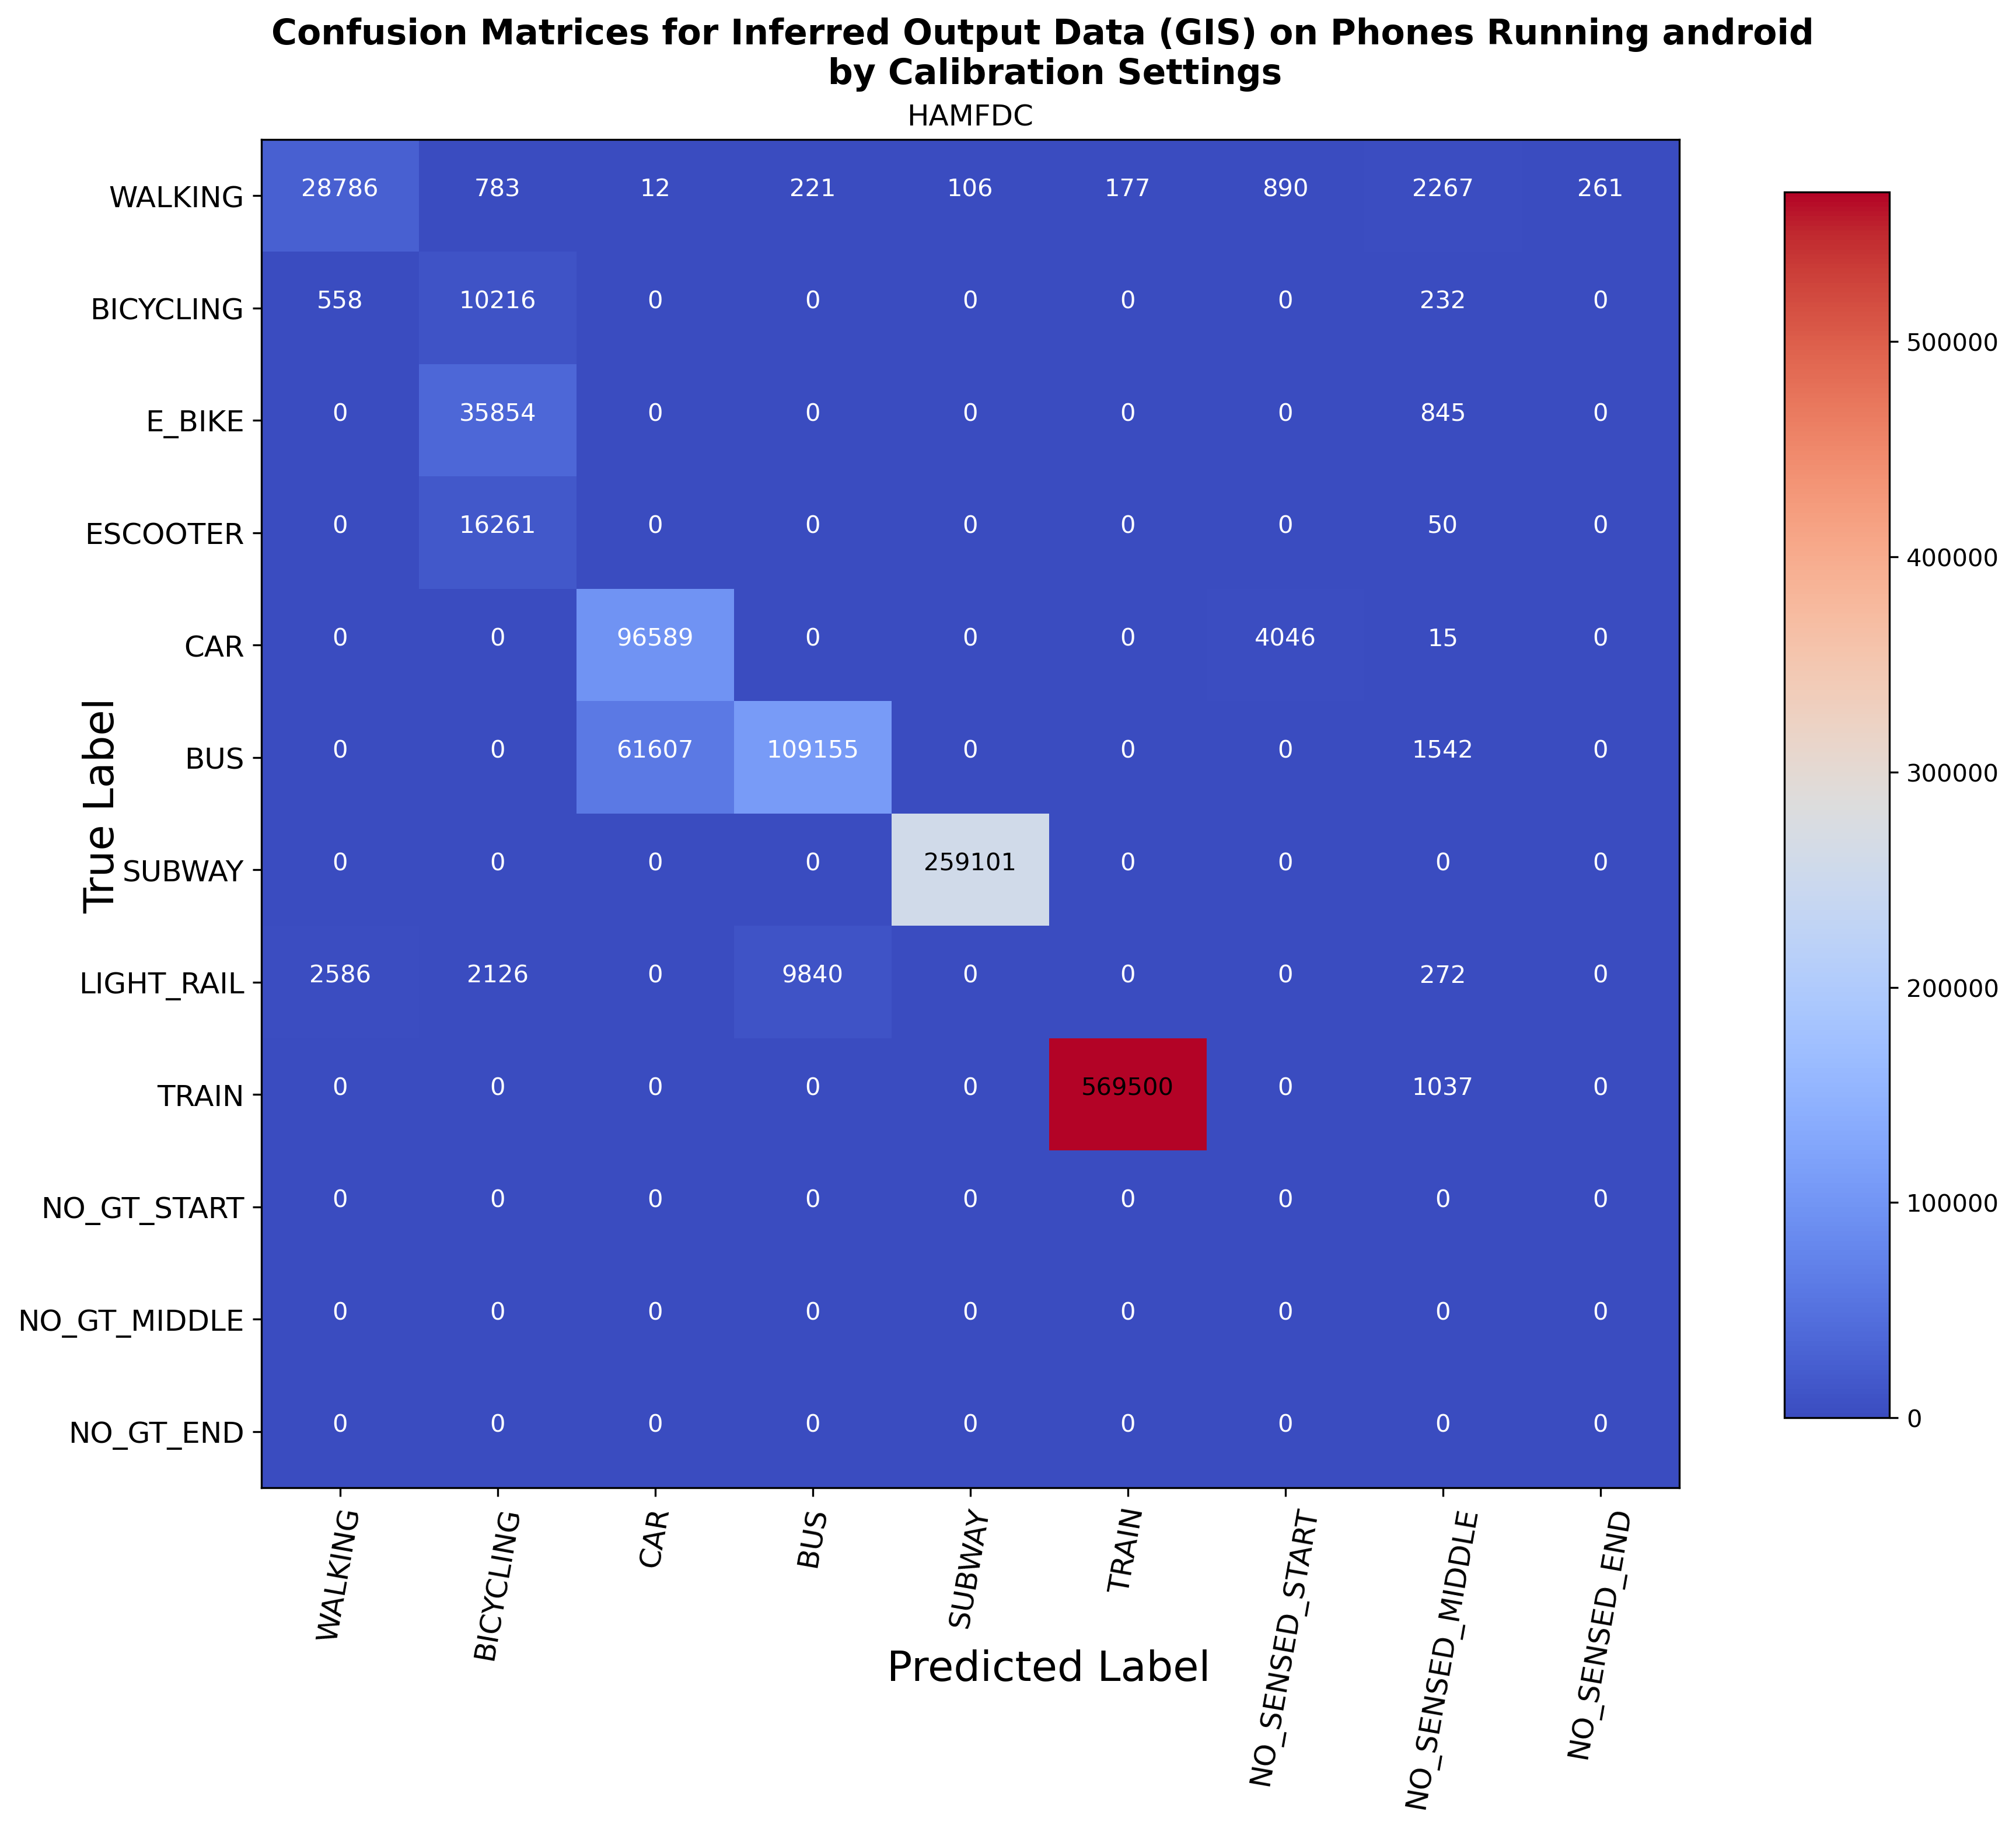

In [43]:
plot_cm_for_one_role('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', role='HAMFDC', INDEX_MAP=IIM, criterion='distance')

GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: WALKING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: NO_SENSED
GT: E_BIKE, Predicted: CYCLING
GT: E_BIKE, Predicted: CYCLING


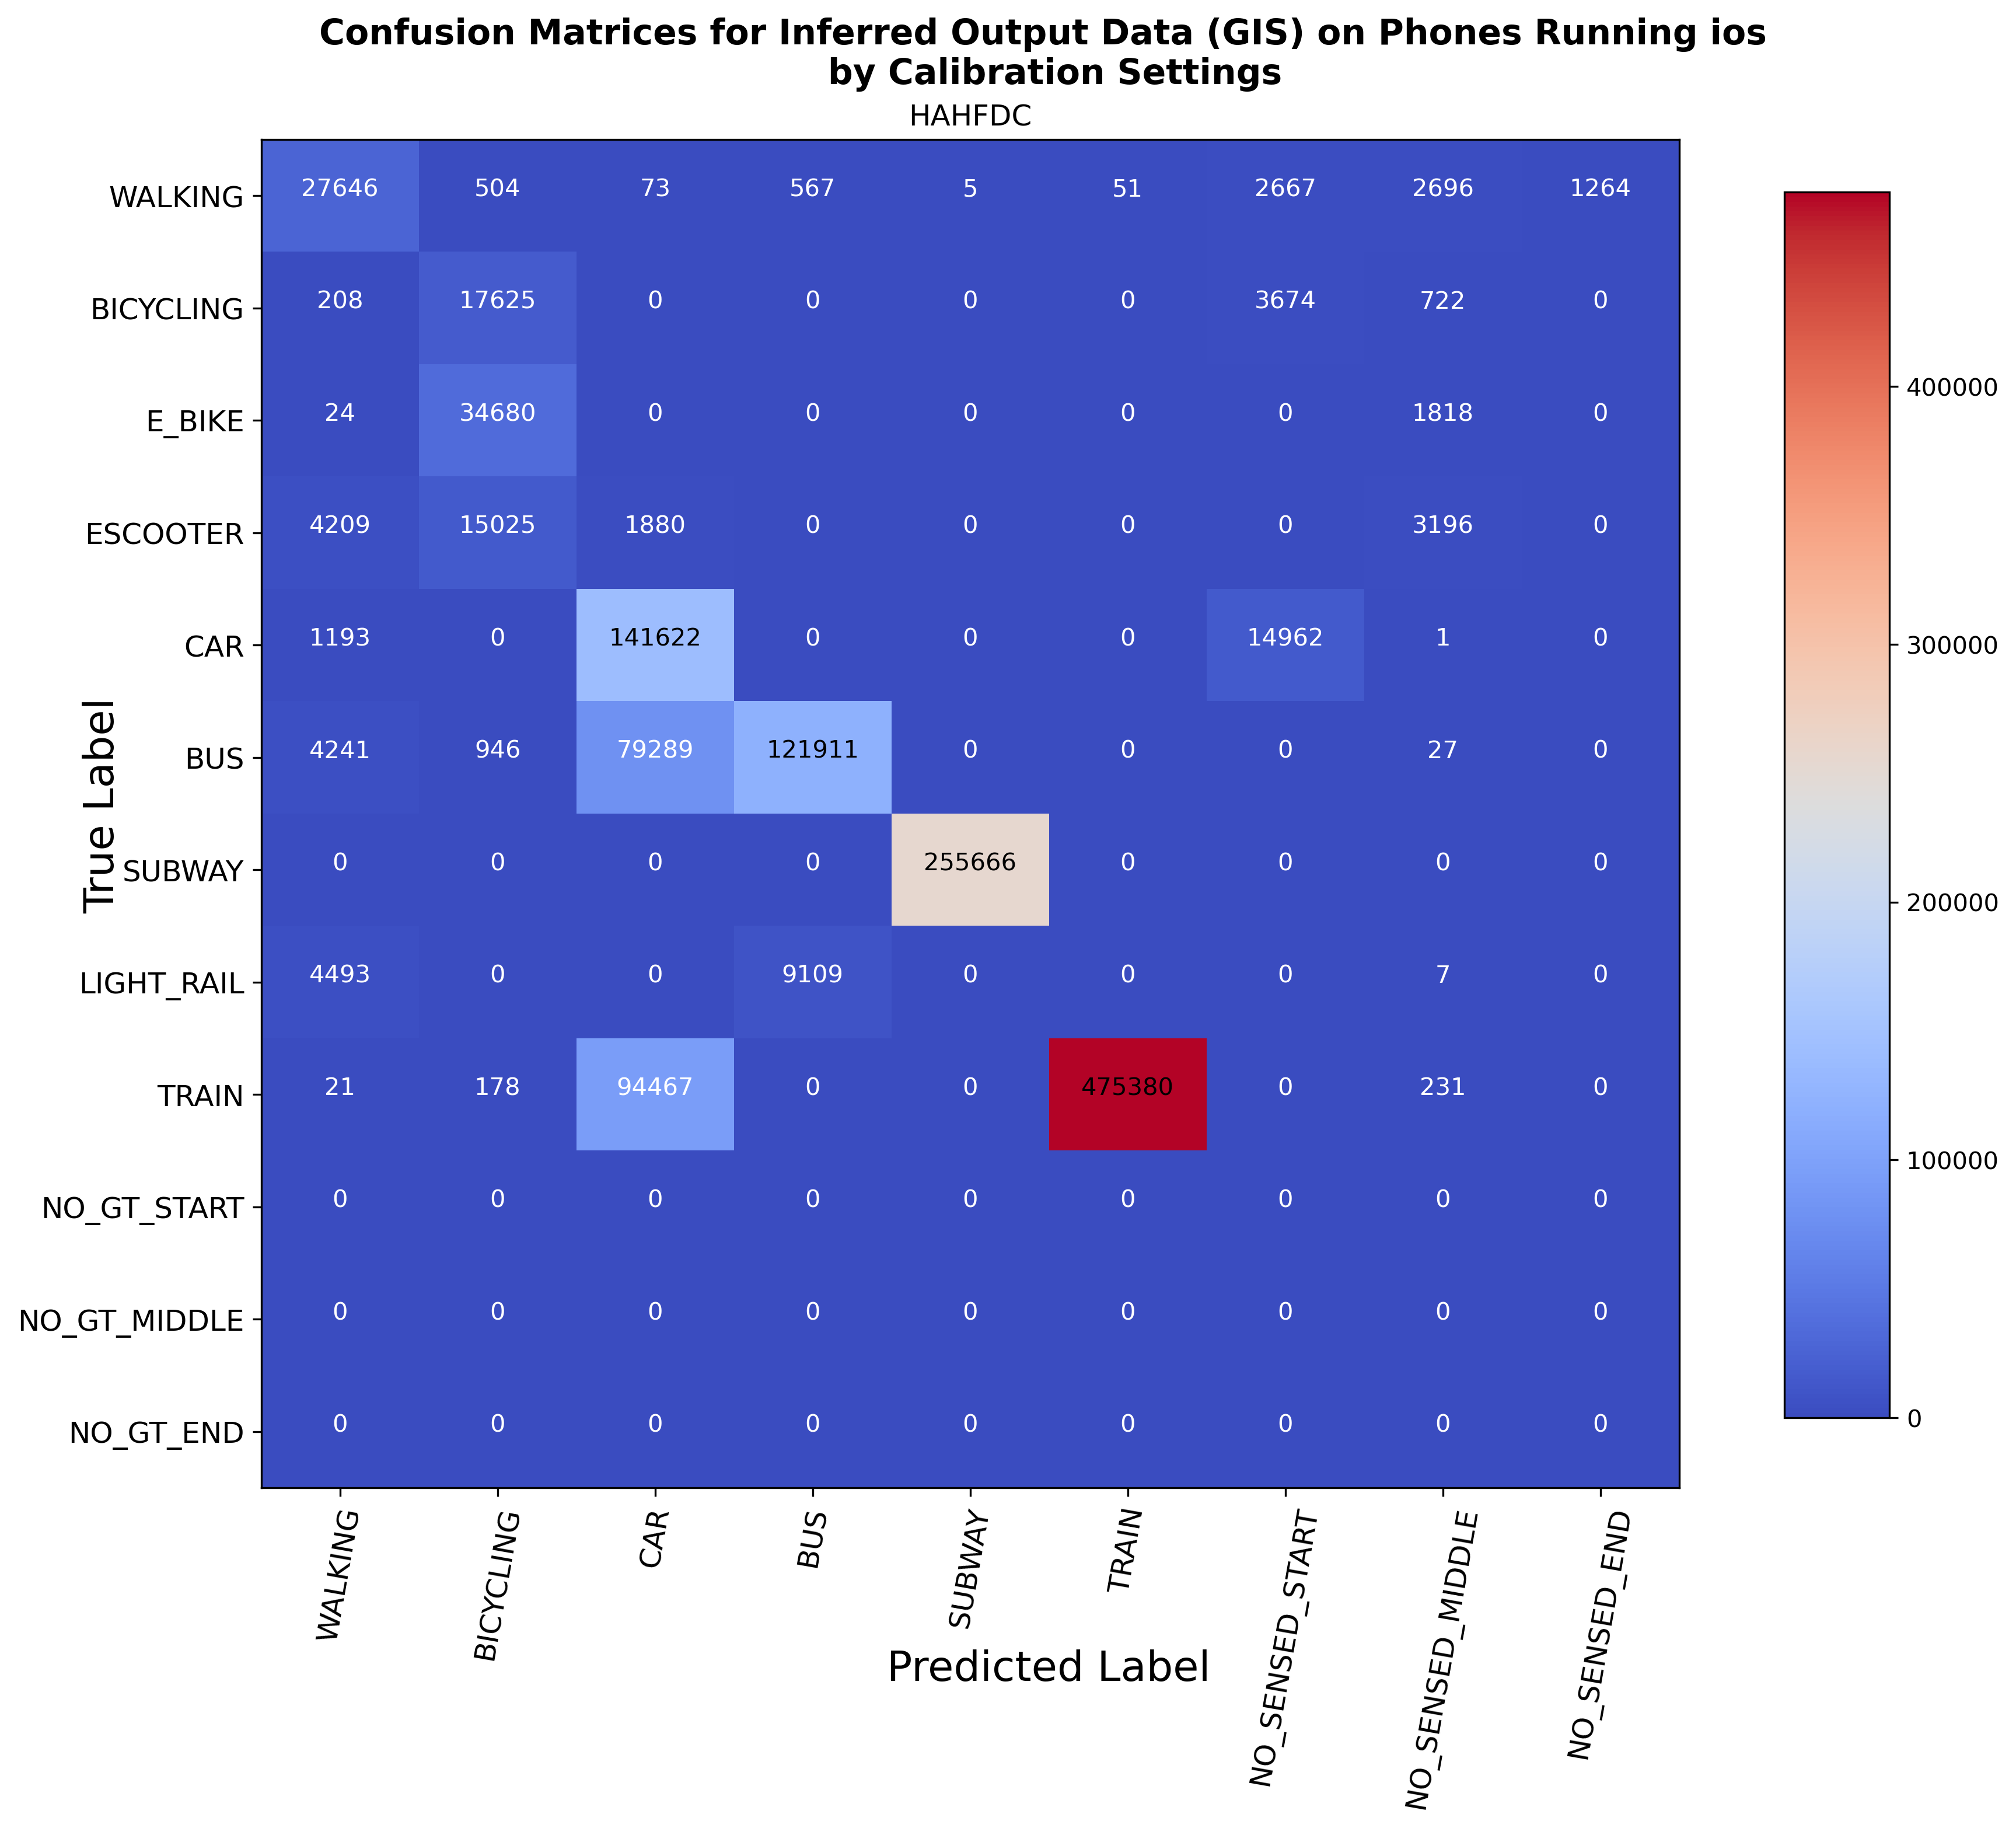

In [44]:
plot_cm_for_one_role('ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', role='HAHFDC', INDEX_MAP=IIM, criterion='distance')

In [ ]:
android_confusion_GIS_HAMFDC = get_confusion_matrix_df(
    'android', [gisv_la,gisv_sj,gisv_ucb], 'gis', phone_configuration = 'HAMFDC', INDEX_MAP=IIM, criterion='distance'
    )

ios_confusion_GIS_HAHFDC = get_confusion_matrix_df(
    'ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', phone_configuration = 'HAHFDC', INDEX_MAP=IIM, criterion='distance'
    )
    
%store android_confusion_GIS_HAMFDC
%store ios_confusion_GIS_HAHFDC

## Analyzed Data

#### cleaned view

In [35]:
import copy

In [36]:
MASTER_DATA_LOC = "bin/data/master_9b70c97"
master_spec = eisd.FileSpecDetails(MASTER_DATA_LOC, AUTHOR_EMAIL)

In [37]:
GIS_DATA_LOC = "bin/data/gis_9b679e3/"
gis_spec = eisd.FileSpecDetails(GIS_DATA_LOC, AUTHOR_EMAIL)

In [ ]:
%%capture
mcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

In [ ]:
%%capture
gcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

#### inferred view random forest

sensed_db

In [ ]:
%%capture
rfv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

#### inferred view GIS
mobilitynet_db

In [38]:
%%capture
gisv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

# Results 

#### Raw data

In [ ]:
compare_cm(oses=['ios'], roles=['HAHFDC'], criteria=['duration', 'distance'], normalization='pred')

In [ ]:
compare_cm(oses=['ios'], roles=['HAHFDC'], criteria=['duration', 'distance'])

In [ ]:
compare_cm(oses=['android'], roles=['HAMFDC'], criteria=['duration', 'distance'], normalization='pred')

In [ ]:
compare_cm(oses=['android'], roles=['HAMFDC'], criteria=['duration', 'distance'])

In [ ]:
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw', criterion='distance')
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw', criterion='distance', normalization='gt')

In [ ]:
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw', criterion='duration')
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw', criterion='duration', normalization='gt')

In [ ]:
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw', criterion='distance')
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw', criterion='distance', normalization='gt')

In [ ]:
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw', criterion='duration')
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw', criterion='duration', normalization='gt')

#### Cleaned data

In [ ]:
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='distance')
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='distance', normalization='gt')

In [ ]:
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='duration')
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='duration', normalization='gt')

In [ ]:
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='distance')
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='distance', normalization='gt')

In [ ]:
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='duration')
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM, criterion='duration', normalization='gt')

#### Random Forest

In [ ]:
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='distance')
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='distance', normalization='gt')

In [ ]:
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='duration')
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='duration', normalization='gt')

In [ ]:
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='distance')
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='distance', normalization='gt')

In [ ]:
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='duration')
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM, criterion='duration', normalization='gt')

#### GIS

In [ ]:
plot_cm('ios', [gisv_sj, gisv_ucb, gisv_la], 'gis', INDEX_MAP=IIM, criterion='duration')
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM, criterion='distance', normalization='gt')

In [ ]:
plot_cm('ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM, criterion='distance')
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM, criterion='duration', normalization='gt')

In [ ]:
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM, criterion='duration')

In [ ]:
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM, criterion='distance')

## Combined views

In [ ]:
plot_f_scores('ios', criterion='distance')

In [ ]:
plot_f_scores('ios', criterion='duration')

In [ ]:
plot_f_scores('android', criterion='distance')

In [ ]:
plot_f_scores('android', criterion='duration')

## Selected Setting

In [ ]:
plot_select_cm('ios', 'HAHFDC')

In [ ]:
plot_select_cm('android', 'HAMFDC')

In [ ]:
plot_f_scores_selected(criterion='distance')

In [ ]:
plot_f_scores_selected(criterion='duration')

In [ ]:
print(
    "GIS android \t",weighted_f_score('android', 'HAMFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM, criterion='distance'), '\n',
    "GIS ios \t", weighted_f_score('ios', 'HAHFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM, criterion='distance')
)
print(
    "Random Forest android \t",weighted_f_score('android', 'HAMFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM, criterion='distance'), '\n',
    "Random Forest ios \t",weighted_f_score('ios', 'HAHFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM, criterion='distance')
)

#### get percentage of no sensed predicted mode for a given ground truth mode (in this case ground truth mode = walking)

In [ ]:
for pv_l in [[pv_la, pv_sj, pv_ucb],[mcv_la, mcv_sj, mcv_ucb],[rfv_la,rfv_sj,rfv_ucb],[gisv_la,gisv_sj,gisv_ucb]]:
    df = pd.DataFrame(get_confusion_matrix('android', 'HAMFDC', pv_l, criterion='distance')).groupby('sensed_mode').sum().rename(index=IIM)
    w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    print("NO_SENSED trip perdiction for WALKING android:HAMFDC: \t", w_n / df['WALKING'].sum())
    df = pd.DataFrame(get_confusion_matrix('ios', 'HAHFDC', pv_l, criterion='distance')).groupby('sensed_mode').sum().rename(index=IIM)
    try:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    except:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'])
    print("NO_SENSED trip perdiction for WALKING ios:HAHFDC: \t", w_n / df['WALKING'].sum())

# Unit Testing

* get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None)
* get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None)
* get_confusion_matrix(os, role, pv, test=False, test_trip=None)

## Example timelines

### No sensed at the beggining, No GT at the end, Multimodal


* pipeline timeline

WALKING (0.5, 1.35) -> CYCLING (1.35, 2.7) -> WALKING (2.7, 3.5)

* ground truth timeline

WALKING (0, 1.05) -> BICYCLING (1.05, 3.1)

#### binary classifiers
    + TP 
        + [WALKING: 0.55] 
        + [CYCLING: 1.35]
    + FP 
        + [WALKING: 1.10] 
        + [INVALID: 0.5]
    + FN 
        + [WALKING: 0.50] 
        + [CYCLING: 0.70]
        + [INVALID: 0.4]
    + TN 
        + [WALKING: 1.35] 
        + [CYCLING: 1.45]
        + [INVALID: 2.60]
* $F_1$ score
    + [WALKING: 0.41]
    + [CYCLING: 0.79]
    + [INVALID: ....]
    
#### Confusion Matrix


sensed = [WALKING, CYCLING, NO_SENSED]

ground truth = [WALKING, BICYCLING, NO_GT]

origin top left

    [0.55, 0.00, 0.50]
    [0.70, 1.35, 0.00]
    [0.40, 0.00, 0.00]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.35, 'mode' : 'WALKING'},
                      {'start_ts' : 1.35, 'end_ts' : 2.7, 'mode' : 'CYCLING'}, 
                      {'start_ts' : 2.7, 'end_ts' : 3.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1.05, 'mode' : 'WALKING'}, 
                      {'start_ts' : 1.05, 'end_ts' : 3.1, 'mode' : 'BICYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'BICYCLING' : 'CYCLING', 
            'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID', 
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

#### get_binary_class_in_sec

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert round(res[0]['WALKING'], 2) == 0.55 and round(res[0]['CYCLING'], 2) == 1.35, f"TP wrong"
assert round(res[1]['WALKING'], 2) == 1.10 and round(res[1]['INVALID'], 2) == 0.50 and len(res[1]) == 2, f"FP wrong"
assert round(res[2]['WALKING'], 2) == 0.50 and round(res[2]['CYCLING'], 2) == 0.70 and round(res[2]['INVALID'], 2) == 0.40 and len(res[2]) == 3, f"FN wrong"
assert round(res[3]['WALKING'], 2) == 1.35 and round(res[3]['CYCLING'], 2) == 1.45 and round(res[3]['INVALID'], 2) == 2.60 and len(res[2]) == 3, f"TN wrong"

#### get_F_score

In [ ]:
res = get_F_score(..., ..., ..., test_BMM, beta=1, test=True, test_trip=test_trip)
assert round(res['WALKING'],2) == 0.41 and round(res['CYCLING'], 2) == 0.79 and res['INVALID'] == 0, f"F_1 scores wrong"

#### get_confusion_matrix

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()
assert 'WALKING' in df.index and 'CYCLING' in df.index and 'NO_SENSED_START' in df.index, f"INCORRECT INDECIES \n EXPECTED \t 'WALKING', 'CYCLING', 'NO_SENSED' \n GOT \t \t {df.index}"
assert df.loc['WALKING'].loc['WALKING'] == 0.55 and df.loc['WALKING'].loc['BICYCLING'] == 0.70 and round(df.loc['WALKING'].loc['NO_GT_END'],2) == 0.40
assert df.loc['CYCLING'].loc['WALKING'] == 0 and df.loc['CYCLING'].loc['BICYCLING'] == 1.35 and round(df.loc['CYCLING'].loc['NO_GT_END'],2) == 0.0
assert round(df.loc['NO_SENSED_START'].loc['WALKING'], 2) == 0.50 and df.loc['NO_SENSED_START'].loc['BICYCLING'] == 0.0 and round(df.loc['NO_SENSED_START'].loc['NO_GT_END'],2) == 0.0

### No sensed at beggining and end, multimodal

* pipeline timeline
WALKING (0.5, 1.5)

* ground truth timeline
WALKING (0, 1) -> (1, 2)

#### Multiclass classifiers
* TP
    + WALKING [0.5]
* FP
    + WALKING [0.5]
    + INVALID [1]
* FN
    + WALKING [0.5]
    + CYCLING [1]
* TN
    + WALKING [0.5]
    + CYCLING [1]
    + INVALID [1]
#### Confusion Matrix

sensed mode = ['WALKING', 'NO_SENSED']

ground truth = ['WALKING', 'CYCLING']

    [0.5, 0.5]
    [0.5, 0.5]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1, 'mode' : 'WALKING'}, {'start_ts' : 1, 'end_ts' : 2, 'mode' : 'CYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : "CYCLING", 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 0.5
assert res[1]['INVALID'] == 1.0 and res[1]['WALKING'] == 0.5
assert res[2]['WALKING'] == 0.5 and res[2]['CYCLING'] == 1 
assert res[3]['WALKING'] == 0.5 and res[3]['CYCLING'] == 1 and res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 0.5
assert df.loc['WALKING'].loc['CYCLING'] == 0.5
assert df.loc['NO_SENSED_START'].loc['WALKING'] == 0.5
assert df.loc['NO_SENSED_END'].loc['CYCLING'] == 0.5

### No ground truth at beggining and end, unimodal

* pipeline timeline
WALKING (0, 2)

* ground truth timeline
WALKING (0.5, 1.5)

#### Multiclass classifiers
* TP
    + WALKING [1]
* FP
    + WALKING [1]
* FN
    + INVALID [1]
* TN
    + INVALID [1]
* $F_1$ score
    + ...
#### Confusion Matrix

sensed mode = ['WALKING']

ground truth = ['WALKING', 'NO_GT]

    [1,1]

In [ ]:
test_trip = {
    'gts_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'ss_timeline' : [{'start_ts' : 0, 'end_ts' : 2, 'mode' : 'WALKING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 1
assert res[1]['WALKING'] == 1
assert res[2]['INVALID'] == 1
assert res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 1
assert df.loc['WALKING'].loc['NO_GT_START'] == 0.5
assert df.loc['WALKING'].loc['NO_GT_END'] == 0.5

## Unimodal Sensed Timeline With Gap

* sensed timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* ground truth timeline
    + WALKING(0, 10)
    
#### Classifiers

* TP
    + WALKING [2]
* FP
    + NO_SENSED [6]
    + CYCLING [2]
* FN
    + WALKING [8]
* TN
    + INVALID [4]
    + CYCLING [8]

In [ ]:
test_trip = [
    {
        'gts_timeline'  : [{'start_ts' : 0, 'end_ts' : 10, 'mode' : 'WALKING'}],
        'ss_timeline' : [
            {'start_ts' : 2, 'end_ts' : 4, 'mode' : 'WALKING'},
            {'start_ts' : 6, 'end_ts' : 8, 'mode' : 'CYCLING'}
        ]
    }
]
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'NO_SENSED' : 'NO_SENSED', 'NO_GT' : 'NO_GT',
            'NO_SENSED_START' : 'NO_SENSED', 'NO_SENSED_MIDDLE' : 'NO_SENSED', 'NO_SENSED_END' : 'NO_SENSED', 
            'NO_GT_START' : 'NO_GT', 'NO_GT_MIDDLE' : 'NO_GT', 'NO_GT_END' : 'NO_GT'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['NO_SENSED'] == 6, f"NO_SENSED FP IS INCORRECT, SHOULD BE 6, GOT {res[1]['NO_SENSED']}"
assert res[1]['CYCLING'] == 2, f"CYCLING FP IS INCORRECT, SHOULD BE 2, GOT {res[1]['CYCLING'] }"
assert res[2]['WALKING'] == 8, f"WALKING FN IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING'] }"
assert res[3]['NO_SENSED'] == 4, f"NO_SENSED TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_SENSED']}"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_GT'] == 10, f"NO_GT TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_GT']}"

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

## Unimodal Sensed Timeline With Gap
### Flip of last trip
* ground truth timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* sensed timeline
    + WALKING(0, 10)

In [ ]:
flip = [{'gts_timeline' : test_trip[0]['ss_timeline'], 'ss_timeline' : test_trip[0]['gts_timeline']}]

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=flip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['WALKING'] == 8, f"WALKING FP IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING']}"
assert res[2]['NO_GT'] == 6, f"NO_GT TN IS INCORRECT, SHOULD BE 6, GOT {res[3]['NO_GT'] }"
assert res[2]['CYCLING'] == 2, f"CYCLING TN IS INCORRECT, SHOULD BE 2, GOT {res[3]['CYCLING'] }"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_SENSED'] == 10, f"NO_SENSED TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_SENSED']}"
assert res[3]['NO_GT'] == 4, f"NO_GT TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_GT']}"

## No ss, gts

In [ ]:
test_trip = [{'gts_timeline'  : [], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No ss

In [ ]:
test_trip = [{'gts_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No gts

In [ ]:
test_trip = [{'ss_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'gts_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)